In [1]:
import json
import pickle
import torch
import torchvision

import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from torch.optim.lr_scheduler import StepLR
from torch.nn.functional import gelu as gelu
from torchvision import transforms

## Fetch and visualize the dataset (CIFAR-10)

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((32, 32)),
     transforms.RandomHorizontalFlip(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) 

batch_size = 6 # Batchc size only for visualisation, not for training.

root = './'
train_data = torchvision.datasets.CIFAR10(root, train=True, transform=transform, target_transform=None, download=True)
test_data  = torchvision.datasets.CIFAR10(root, train=False, transform=transform, target_transform=None, download=True)
print(f'We have {len(train_data)} training samples and {len(test_data)} test samples.')

Files already downloaded and verified
Files already downloaded and verified
We have 50000 training samples and 10000 test samples.


In [3]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

In [4]:
with open("cifar-10-batches-py/batches.meta", 'rb') as pickleFile:
    cifar10_classes = pickle.load(pickleFile)['label_names']

In [5]:
cifar10_classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

Shape of one batch of images is: torch.Size([6, 3, 32, 32])


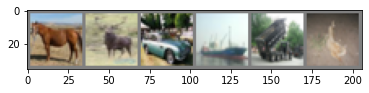

Label: horse Label: deer Label: automobile Label: ship Label: truck Label: cat


In [6]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(f'Shape of one batch of images is: {images.size()}')

img = torchvision.utils.make_grid(images)
img = img / 2 + 0.5 # Unnormalize
npimg = img.numpy()

plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()
    
print(' '.join(f'Label: {cifar10_classes[int(labels[j])]}' for j in range(batch_size)))

## Define MLP-Mixer Architecture

In [7]:
class MLP(nn.Module):
    def __init__(self, num_hidden_dim, dropout, mlp_dim_factor):
        """
        Single MLP, as defined in the paper, contains two fully-connected layers
        and a GELU nonlinearity.
        
        num_hidden_dim * mlp_dim_factor: hidden mlp width in token mixing/channel mixing.
        """
        super().__init__()
        self.fc1 = nn.Linear(num_hidden_dim, num_hidden_dim * mlp_dim_factor)
        self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(num_hidden_dim * mlp_dim_factor, num_hidden_dim)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x):
        x = self.dropout1(gelu(self.fc1(x)))
        x = self.dropout2(self.fc2(x))
        return x


class TokenMixer(nn.Module):
    def __init__(self, num_hidden_dim, num_patches, dropout, mlp_dim_factor):
        super().__init__()
        self.layer_norm = nn.LayerNorm(num_hidden_dim)
        self.mlp = MLP(num_patches, dropout, mlp_dim_factor)

    def forward(self, x):
        residual = x # (B, S, D)
        x = self.layer_norm(x)
        x = x.transpose(1, 2) # (B, D, S)
        x = self.mlp(x) # (B, D, S)
        x = x.transpose(1, 2) # (B, S, D)
        out = x + residual
        return out

class ChannelMixer(nn.Module):
    def __init__(self, num_hidden_dim, num_patches, dropout, mlp_dim_factor):
        super().__init__()
        self.layer_norm = nn.LayerNorm(num_hidden_dim)
        self.mlp = MLP(num_hidden_dim, dropout, mlp_dim_factor)

    def forward(self, x):
        residual = x # (B, S, D) 
        x = self.layer_norm(x)
        x = self.mlp(x) # (B, S, D)
        out = x + residual
        return out


class MixerLayer(nn.Module):
    def __init__(self, num_hidden_dim, num_patches, dropout, mlp_dim_factor):
        super().__init__()
        self.token_mixer = TokenMixer(num_hidden_dim, num_patches, dropout, mlp_dim_factor)
        self.channel_mixer = ChannelMixer(num_hidden_dim, num_patches, dropout, mlp_dim_factor)

    def forward(self, x):
        x = self.token_mixer(x) # (B, S, D)
        x = self.channel_mixer(x) # (B, S, D)
        return x
    

class MLPMixer(nn.Module):
    def __init__(self, image_shape, patch_size, num_channels, num_hidden_dim, 
                 num_layers, num_classes, dropout, mlp_dim_factor):
        super().__init__()
        
        # check if a HxH image can be split to S PxP patches
        quotient, modulo = divmod(image_shape[0] * image_shape[1], patch_size**2)
        if modulo:
            raise ValueError("Cannot divide the image into (patch_size, patch_size) patches.")
        else: 
            self.num_patches = quotient
            print(f"Divided image of dimensions {image_shape} into {self.num_patches} {patch_size}x{patch_size} patches")
        
        # Strided conv2 equals: patching the image + embedding every patch to a vector.
        self.patch_embedd = nn.Conv2d(num_channels, num_hidden_dim, kernel_size=patch_size, stride=patch_size)
        
        self.mixer_layers = nn.Sequential(
            *[MixerLayer(num_hidden_dim, self.num_patches, dropout, mlp_dim_factor) for _ in range(num_layers)])
        self.logit_generator = nn.Linear(num_hidden_dim, num_classes)
        
    def forward(self, x):
        patches = self.patch_embedd(x)
        B, D, _, _ = patches.shape
        patches = patches.permute(0, 2, 3, 1)
        patches = patches.view(B, -1, D) # (B, S, D)
        assert patches.shape[1] == self.num_patches
        output = self.mixer_layers(patches) # (B, S, D)
        output = output.mean(dim = 1) # (B, D)
        
        return self.logit_generator(output)
        

## Train the MLP-Mixer Classifier

In [8]:
# The hyperaparameters are chosen very roughly, not much time spent on it.
epochs = 50
print_save_every = 10
batch_size = 32
device = 'cpu'
lr = 3e-5
gamma = 0.7
num_classes = 10
patch_size = 8

In [9]:
mlp_mixer = MLPMixer(image_shape = (32, 32), patch_size = patch_size, num_channels = 3, 
                     num_hidden_dim = 128, num_layers=6, num_classes=num_classes, dropout=0.2, mlp_dim_factor=2)

Divided image of dimensions (32, 32) into 16 8x8 patches


In [10]:
mlp_mixer

MLPMixer(
  (patch_embedd): Conv2d(3, 128, kernel_size=(8, 8), stride=(8, 8))
  (mixer_layers): Sequential(
    (0): MixerLayer(
      (token_mixer): TokenMixer(
        (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (fc1): Linear(in_features=16, out_features=32, bias=True)
          (dropout1): Dropout(p=0.2, inplace=False)
          (fc2): Linear(in_features=32, out_features=16, bias=True)
          (dropout2): Dropout(p=0.2, inplace=False)
        )
      )
      (channel_mixer): ChannelMixer(
        (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (fc1): Linear(in_features=128, out_features=256, bias=True)
          (dropout1): Dropout(p=0.2, inplace=False)
          (fc2): Linear(in_features=256, out_features=128, bias=True)
          (dropout2): Dropout(p=0.2, inplace=False)
        )
      )
    )
    (1): MixerLayer(
      (token_mixer): TokenMixer(
        (layer_norm): LayerNo

In [11]:
parameters = filter(lambda p: p.requires_grad, mlp_mixer.parameters())
parameters = sum([np.prod(p.size()) for p in parameters]) / 1_000_000
print('Trainable Parameters: %.3fM' % parameters)

Trainable Parameters: 0.431M


In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_mixer.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [ ]:
training_curve_data = {}

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    for data, label in iter(trainloader):
        data = data.to(device)
        label = label.to(device)

        output = mlp_mixer(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(trainloader)
        epoch_loss += loss / len(trainloader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in validloader:
            data = data.to(device)
            label = label.to(device)

            val_output = mlp_mixer(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(validloader)
            epoch_val_loss += val_loss / len(validloader)
            
# ===============================================================================

    training_curve_data[epoch] = {'epoch_train_loss': float(epoch_loss.detach().numpy()),
                                  'epoch_val_loss': float(epoch_val_loss.detach().numpy()),
                                  'epoch_accuracy': float(epoch_accuracy.detach().numpy()),
                                  'epoch_val_accuracy': float(epoch_val_accuracy.numpy())}
    
    with open('training_curve_data.json', 'w') as fp:
        json.dump(training_curve_data, fp)

    if epoch % print_save_every == 0:
        print(
            f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
        )
        torch.save(mlp_mixer.state_dict(), f'model_epoch_{epoch+1}.pth')


## Run Inference

In [13]:
from PIL import Image
plt.rcParams["figure.figsize"] = (15,4)

In [16]:
with open('training_artefacts/training_curve_data.json', 'r') as f:
    training_curve_data = json.load(f)

train_loss, val_loss, train_acc, val_acc = [], [], [], []
idx_epochs = list(training_curve_data.keys())

for key, value in training_curve_data.items():
    train_loss.append(value['epoch_train_loss'])
    val_loss.append(value['epoch_val_loss'])
    train_acc.append(value['epoch_accuracy'])
    val_acc.append(value['epoch_val_accuracy'])

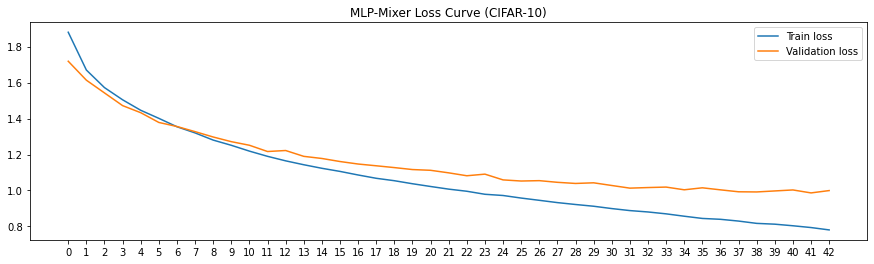

In [19]:
plt.plot(idx_epochs, train_loss, label = "Train loss")
plt.plot(idx_epochs, val_loss, label = "Validation loss")
plt.legend()
plt.title('MLP-Mixer Loss Curve (CIFAR-10)')
plt.show()

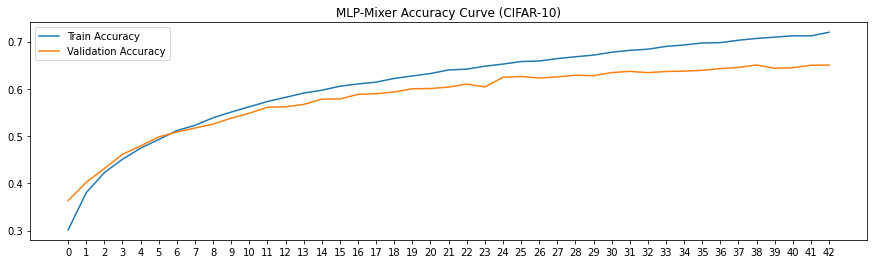

In [22]:
plt.plot(idx_epochs, train_acc, label = "Train Accuracy")
plt.plot(idx_epochs, val_acc, label = "Validation Accuracy")
plt.legend()
plt.title('MLP-Mixer Accuracy Curve (CIFAR-10)')
plt.show()

In [23]:
mlp_mixer.load_state_dict(torch.load('training_artefacts/model_epoch_41.pth'))
mlp_mixer.eval()

MLPMixer(
  (patch_embedd): Conv2d(3, 128, kernel_size=(8, 8), stride=(8, 8))
  (mixer_layers): Sequential(
    (0): MixerLayer(
      (token_mixer): TokenMixer(
        (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (fc1): Linear(in_features=16, out_features=32, bias=True)
          (dropout1): Dropout(p=0.2, inplace=False)
          (fc2): Linear(in_features=32, out_features=16, bias=True)
          (dropout2): Dropout(p=0.2, inplace=False)
        )
      )
      (channel_mixer): ChannelMixer(
        (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (fc1): Linear(in_features=128, out_features=256, bias=True)
          (dropout1): Dropout(p=0.2, inplace=False)
          (fc2): Linear(in_features=256, out_features=128, bias=True)
          (dropout2): Dropout(p=0.2, inplace=False)
        )
      )
    )
    (1): MixerLayer(
      (token_mixer): TokenMixer(
        (layer_norm): LayerNo

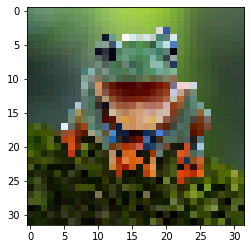

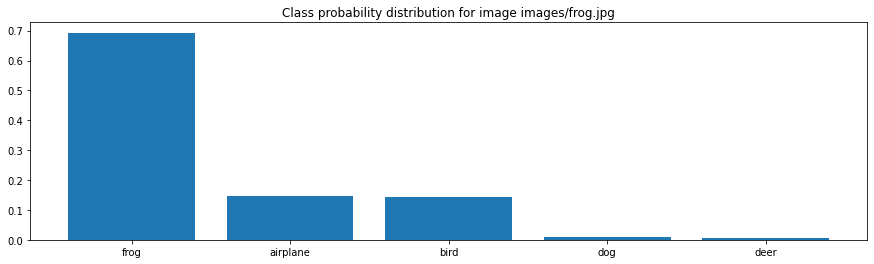

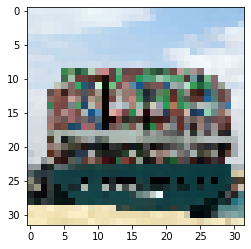

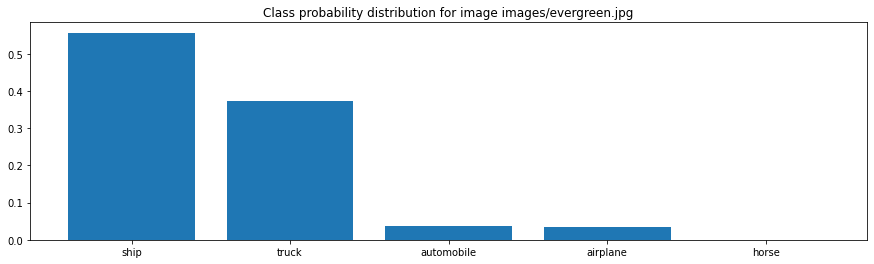

In [24]:
for filename in ['images/frog.jpg', 'images/evergreen.jpg']:
    
    # Read and preprocess
    image = Image.open(filename)
    image = transform(image)
    image = image.unsqueeze(0)
    image = image.to(device)
    
    # Visualize
    img = torchvision.utils.make_grid(image)
    img = img / 2 + 0.5 # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
    # Run Inference
    output = torch.softmax(mlp_mixer(image).squeeze(), dim = 0)
    values, indices = torch.topk(output, k = 5)
    class_names = [cifar10_classes[i] for i in indices.numpy().astype(int)]
    values = values.detach().numpy()
    plt.title(f'Class probability distribution for image {filename}')
    plt.bar(class_names, values)
    plt.show()